House Rent Prediction

Part 1: Data Acquisition

In [3]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

from scipy.stats import probplot, boxcox, f
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
data = pd.read_csv("House_Rent_Dataset.csv")
data.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')

In [5]:
# Identifying the size of the data
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 4746
Number of columns: 12


In [6]:
# expression for extract currunt floor and total no of floors
pattern = r'(?P<CurrentFloor>\w+)\s*out\s*of\s*(?P<TotalFloors>\d+)'

#extract values to new columns
data[['CurrentFloor', 'TotalFloors']] = data['Floor'].str.extract(pattern)

# Replace non numaric values 
floor_replacements = {
    'Ground': 0,
    'Basement': -1  # Basement =  -1
}

data['CurrentFloor'] = data['CurrentFloor'].replace(floor_replacements)

# Convert columns to appropriate data types
data['CurrentFloor'] = pd.to_numeric(data['CurrentFloor'], errors='coerce')
data['TotalFloors'] = pd.to_numeric(data['TotalFloors'], errors='coerce')
data = data.drop(columns=['Floor'])

In [7]:
categorical_columns = data.select_dtypes(include=['object']).columns
unique_counts = data[categorical_columns].nunique()
print(unique_counts)

Posted On              81
Area Type               3
Area Locality        2235
City                    6
Furnishing Status       3
Tenant Preferred        3
Point of Contact        3
dtype: int64


In [8]:
#print missing values of each column
print(f'Number of missing values in DataFrame:\n{data.isna().sum()}')

Number of missing values in DataFrame:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
CurrentFloor         4
TotalFloors          4
dtype: int64


In [9]:
# theres 4 missing values 
# Replace missing values with 0.0 in specified columns
data['CurrentFloor'].fillna(0.0, inplace=True)
data['TotalFloors'].fillna(0.0, inplace=True)
print(f'Number of missing values in DataFrame:\n{data.isna().sum()}')
data.info()

Number of missing values in DataFrame:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
CurrentFloor         0
TotalFloors          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Posted On          4746 non-null   object 
 1   BHK                4746 non-null   int64  
 2   Rent               4746 non-null   int64  
 3   Size               4746 non-null   int64  
 4   Area Type          4746 non-null   object 
 5   Area Locality      4746 non-null   object 
 6   City               4746 non-null   object 
 7   Furnishing Status  4746 non-null   object 
 8   Tenant Preferred   4746 non-null   object 
 9   Bathroom 

C:\Users\Anchal Agrawal\AppData\Local\Temp\ipykernel_27860\2965890589.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CurrentFloor'].fillna(0.0, inplace=True)
C:\Users\Anchal Agrawal\AppData\Local\Temp\ipykernel_27860\2965890589.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

encoding categorical variables

In [11]:
# Dropping duplicate rows
print(data.duplicated().sum())
data = data.drop_duplicates()

0


In [12]:
# Descriptive statistics
data.describe()

BHK          Rent         Size     Bathroom  CurrentFloor  \
count  4746.000000  4.746000e+03  4746.000000  4746.000000   4746.000000   
mean      2.083860  3.499345e+04   967.490729     1.965866      3.437421   
std       0.832256  7.810641e+04   634.202328     0.884532      5.772394   
min       1.000000  1.200000e+03    10.000000     1.000000     -1.000000   
25%       2.000000  1.000000e+04   550.000000     1.000000      1.000000   
50%       2.000000  1.600000e+04   850.000000     2.000000      2.000000   
75%       3.000000  3.300000e+04  1200.000000     2.000000      3.000000   
max       6.000000  3.500000e+06  8000.000000    10.000000     76.000000   

       TotalFloors  
count  4746.000000  
mean      6.967552  
std       9.467898  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       6.000000  
max      89.000000

Part 2: Exploratory Analysis & Pre-Processing
Part 2.1: Numerical Variables

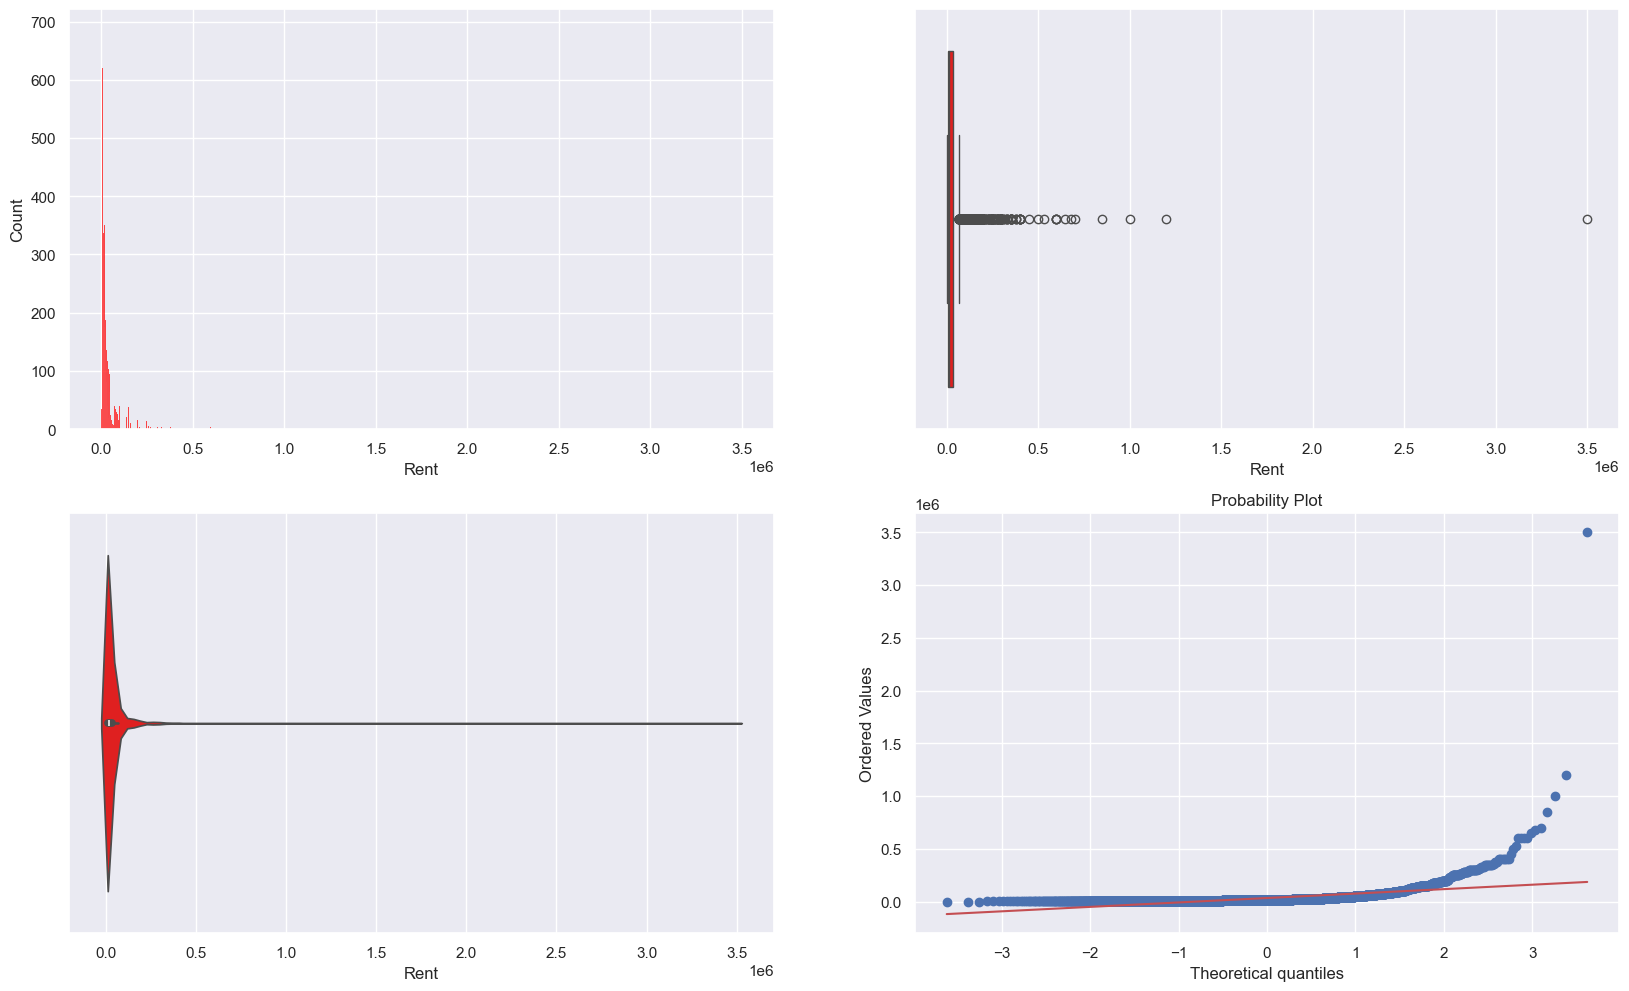

In [14]:
# Checking distribution of Rent
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sb.histplot(x = data['Rent'], color='red', ax= ax[0, 0])
ax2 = sb.boxplot(x = data['Rent'], ax= ax[0, 1], color= 'red')
ax3 = sb.violinplot(x = data['Rent'], ax= ax[1, 0], color= 'red')
ax4 = probplot(data['Rent'], plot=pylab)
pylab.show()

From the plots above, it can be seen that there is an extreme outlier with a value far greater than the rest. To resolve this outlier, I will remove it.

In [16]:
# Finding extreme outlier and removing that index
max_rent = data['Rent'].max()
max_rent_index = data[data['Rent'] == max_rent].index
data = data.drop(max_rent_index)

# Confirming that row has been removed
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 4745
Number of columns: 13


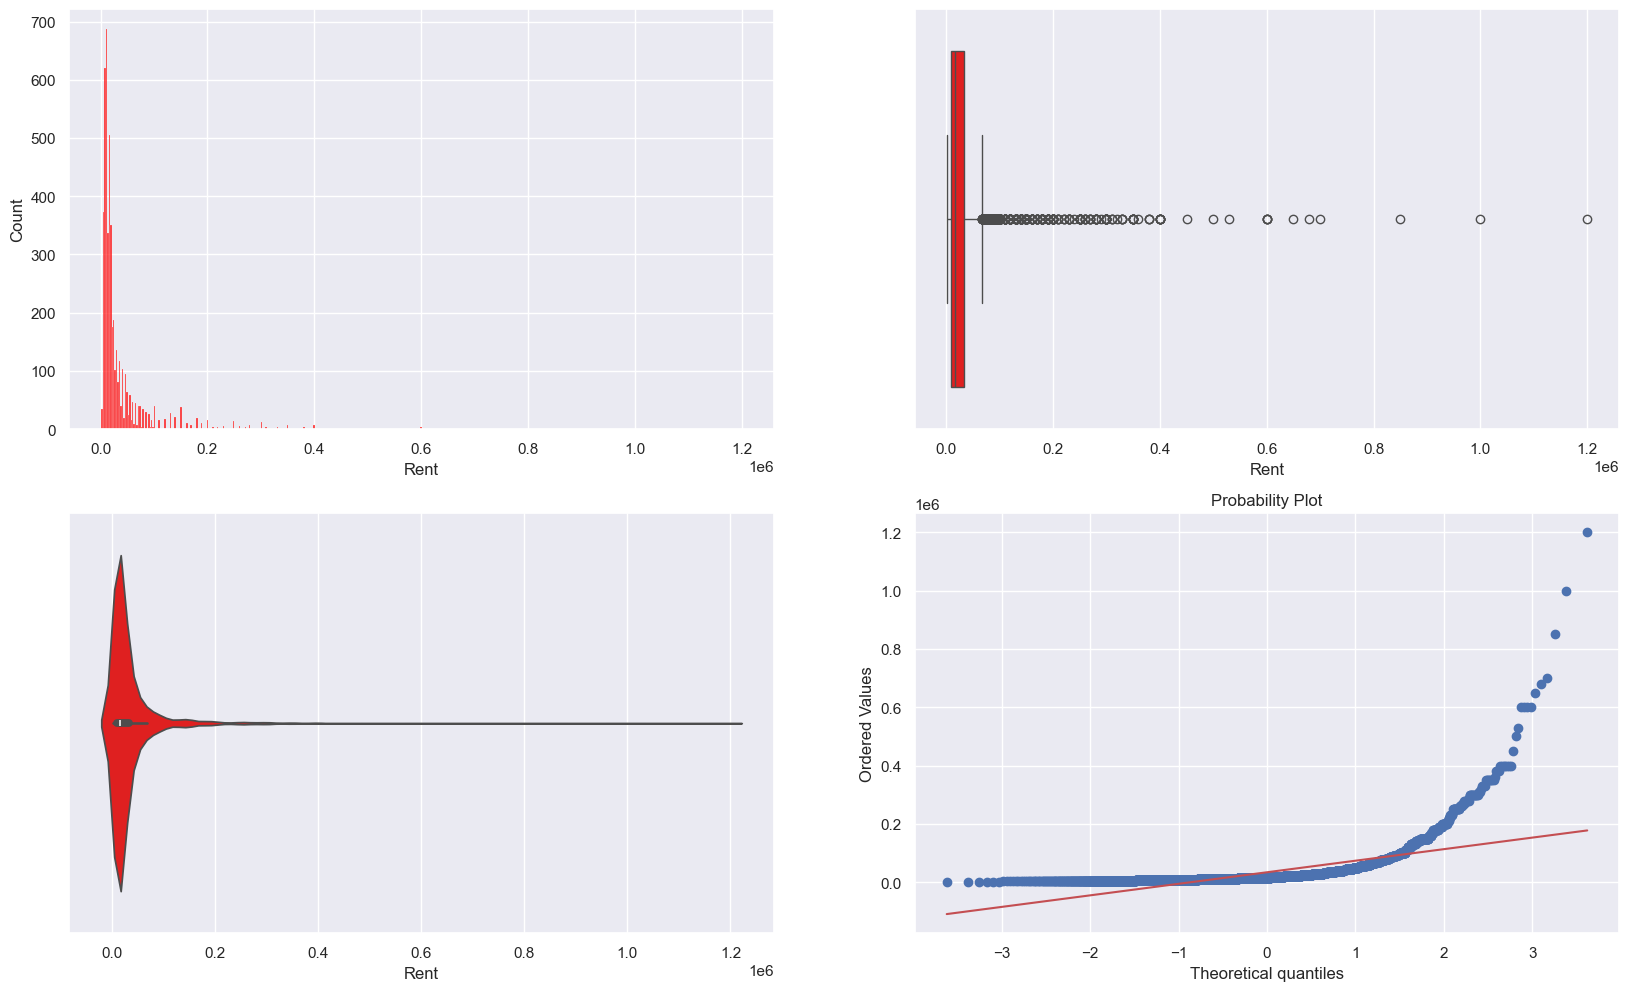

In [17]:
# Replotting distribution of Rent after removal of extreme outlier
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sb.histplot(x = data['Rent'], color='red', ax= ax[0, 0])
ax2 = sb.boxplot(x = data['Rent'], ax= ax[0, 1], color= 'red')
ax3 = sb.violinplot(x = data['Rent'], ax= ax[1, 0], color= 'red')
ax4 = probplot(data['Rent'], plot=pylab)
pylab.show()

The graphs confirm that Rent is positively skewed, as was indicated by having a Mean greater than the Median.

However, the points on the probability plot deviate from the line, indicating that the data is not close to a normal distribution. This may affect the accuracy of the linear regression and other machine learning models negatively.

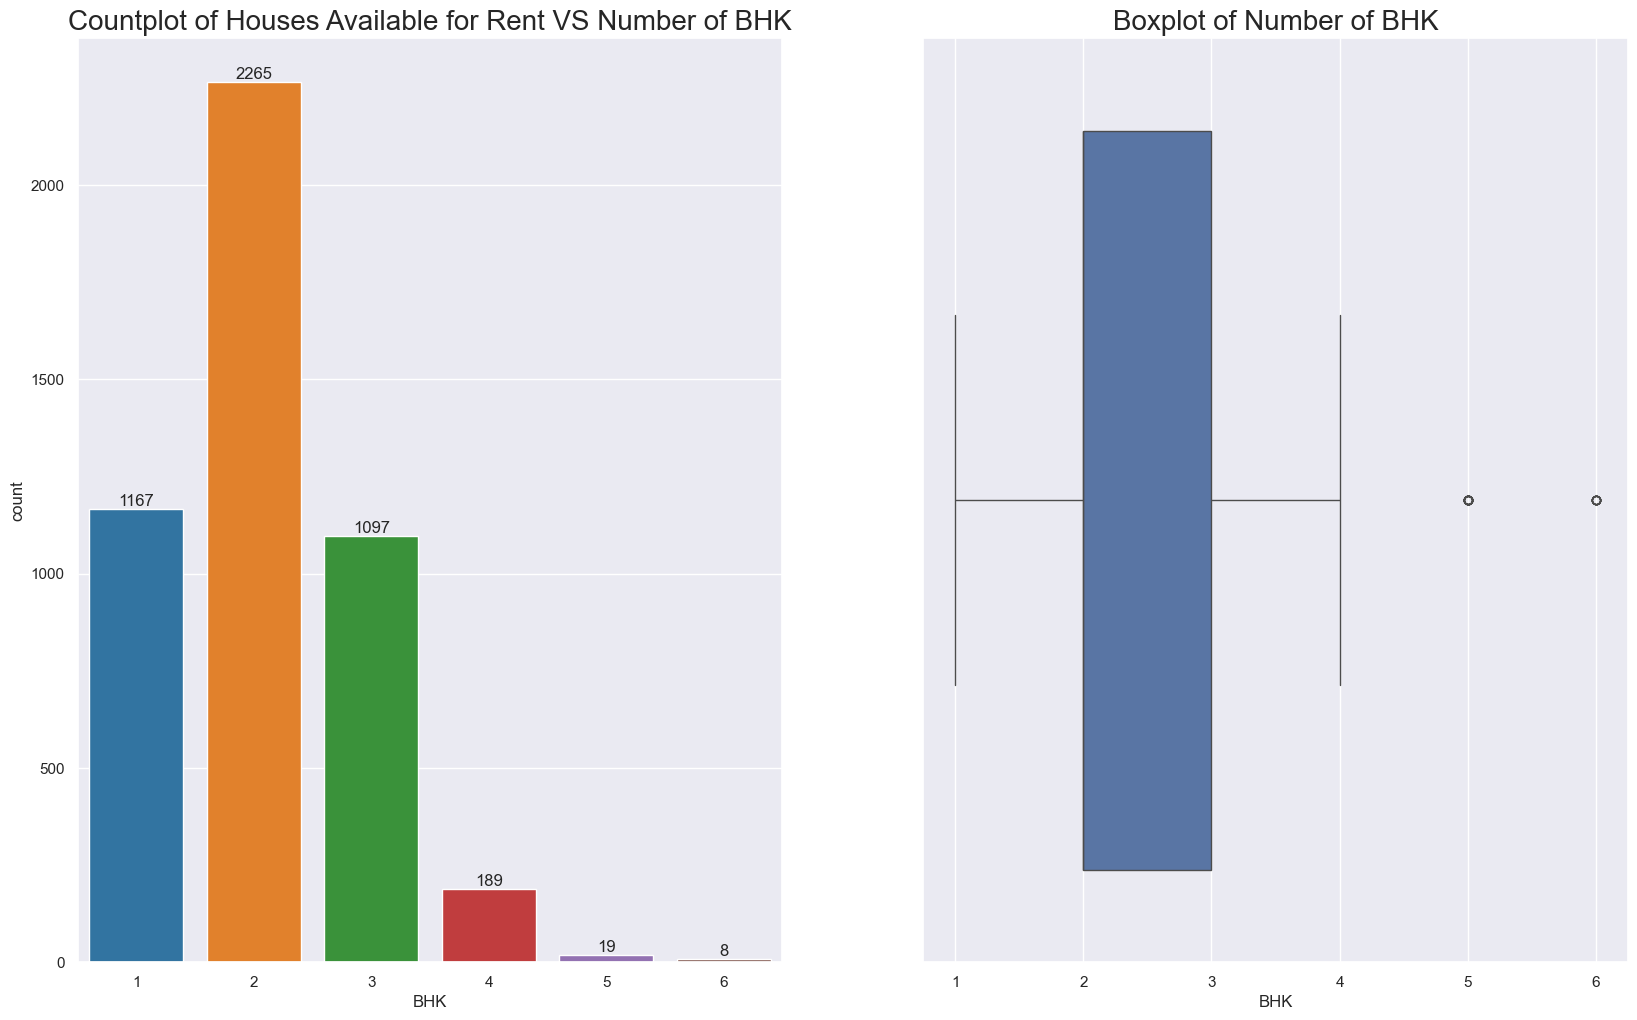

In [19]:
# Countplot of BHK
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax1 = sb.countplot(x='BHK',data=data,palette='tab10',ax=ax[0], hue = 'BHK', legend = False)
for container in ax1.containers:
    ax1.bar_label(container)
ax2 = sb.boxplot(x = data['BHK'], ax= ax[1])
ax1.set_title('Countplot of Houses Available for Rent VS Number of BHK',fontsize=20)
ax2.set_title('Boxplot of Number of BHK',fontsize=20)
plt.show()

From the plot above, most houses put on rent have 2 BHK, while houses with 4 BHK and above are scarce. This may indicate the lesser demand for bigger houses and higher demand for smaller houses in India.

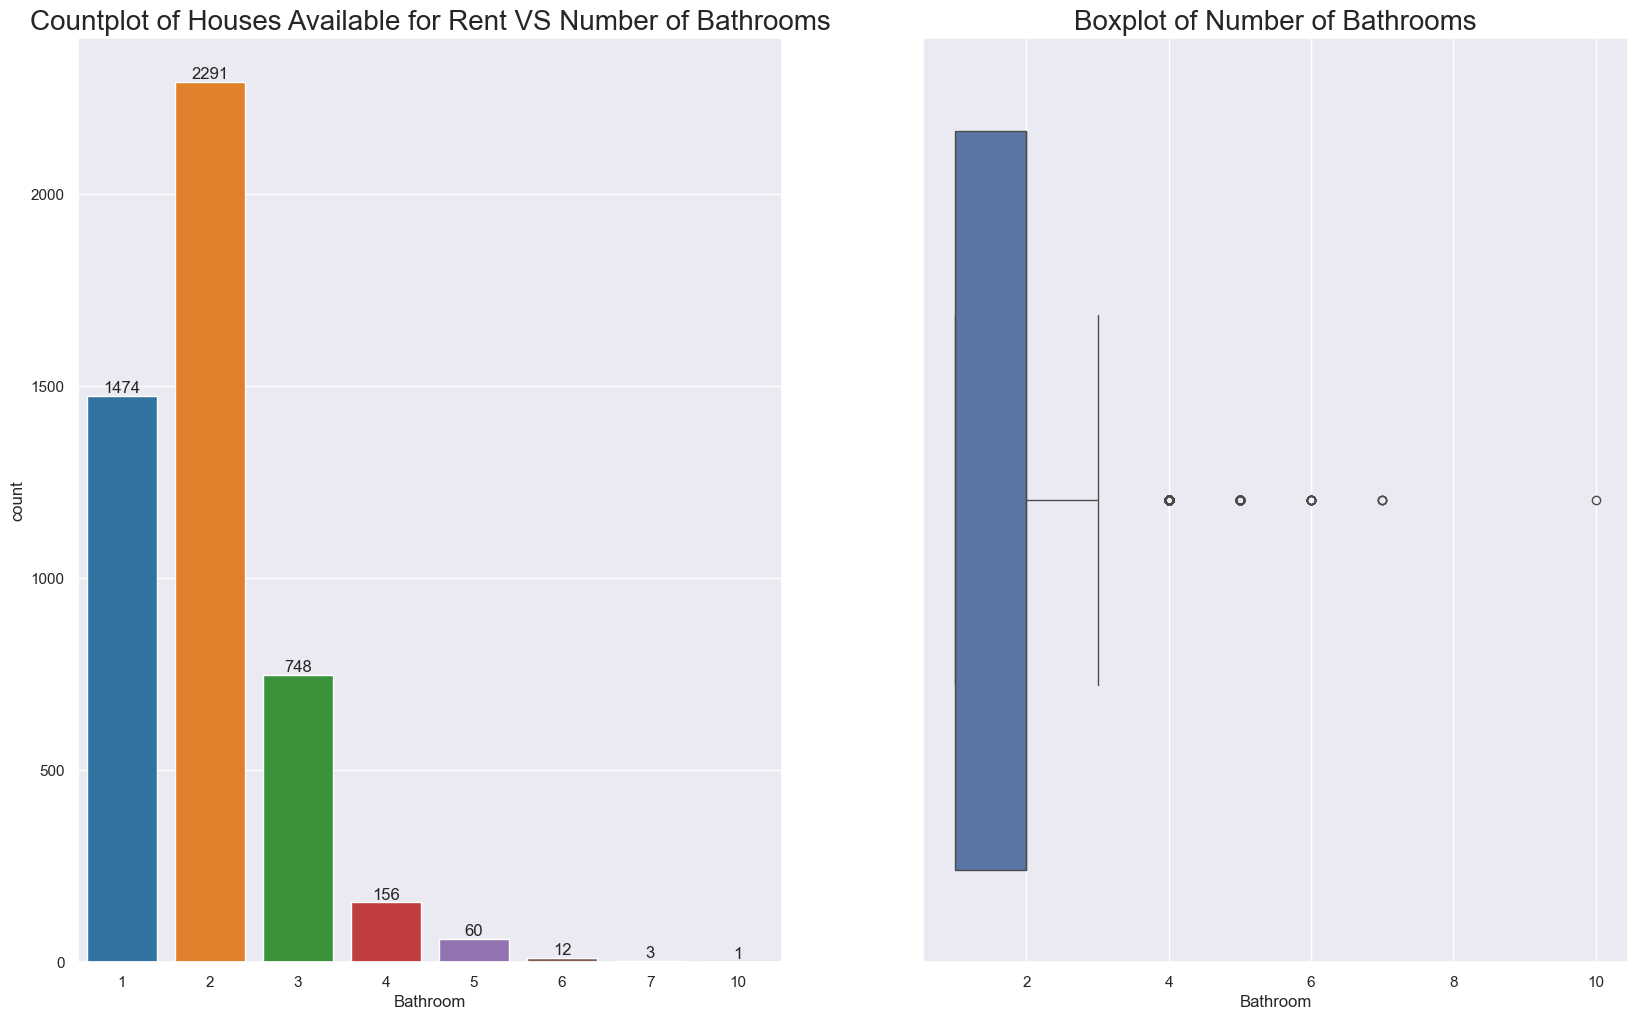

In [21]:
# Countplot of Bathroom
fig, ax = plt.subplots(1, 2, figsize=(20,12))
ax1 = sb.countplot(x='Bathroom',data=data,palette='tab10',ax=ax[0], hue = 'Bathroom', legend = False)
for container in ax1.containers:
    ax1.bar_label(container)
ax2 = sb.boxplot(x = data['Bathroom'], ax= ax[1])
ax1.set_title('Countplot of Houses Available for Rent VS Number of Bathrooms',fontsize=20)
ax2.set_title('Boxplot of Number of Bathrooms',fontsize=20)
plt.show()

From the plot above, most houses put on rent have 2 bathrooms, while houses with 6 bathrooms and above are scarce. This may indicate the lesser demand for bigger houses and higher demand for smaller houses in India.

Part 2.2: Categorical Variables

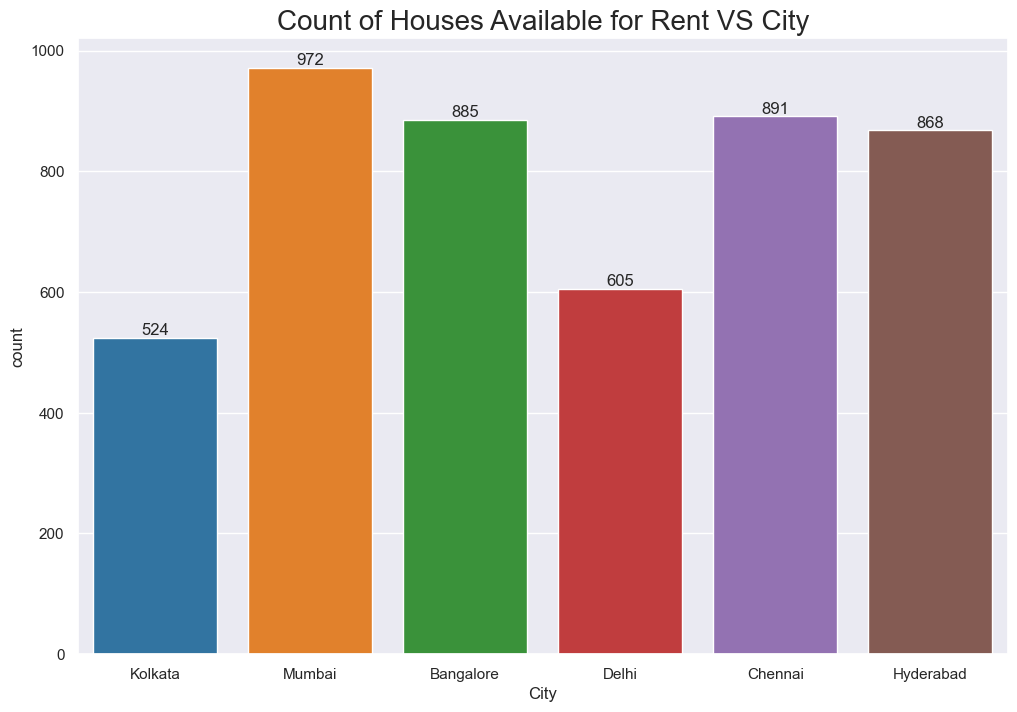

In [24]:
# Countplot of City
fig,axes = plt.subplots(figsize=(12,8))

ax = sb.countplot(x='City',data=data, palette='tab10', hue = 'City', legend = False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count of Houses Available for Rent VS City',fontsize=20)
plt.show()

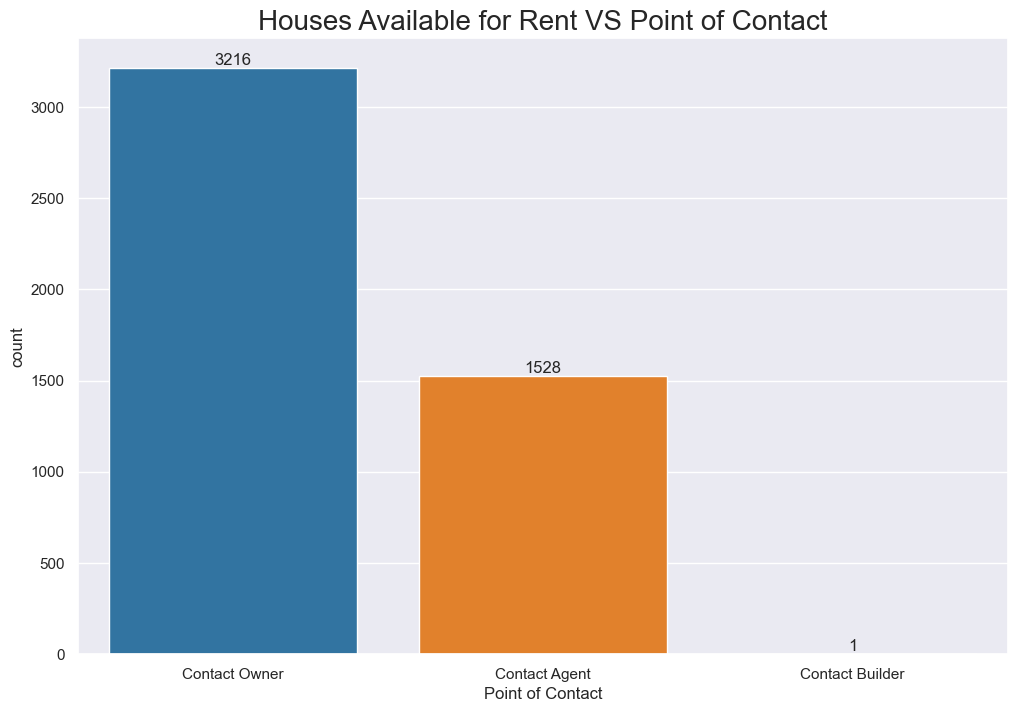

In [25]:
# Countplot of Point of Contact
fig,axes = plt.subplots(figsize=(12,8))

ax = sb.countplot(x='Point of Contact',data=data, palette='tab10', hue = 'Point of Contact', legend = False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Houses Available for Rent VS Point of Contact',fontsize=20)
plt.show()

In [26]:
# Dropping the row with contact builder since it is an extreme outlier
data = data[~data['Point of Contact'].str.contains("Contact Builder")]

# Confirming that rows have been dropped
print("Number of rows:", data.shape[0])

Number of rows: 4744


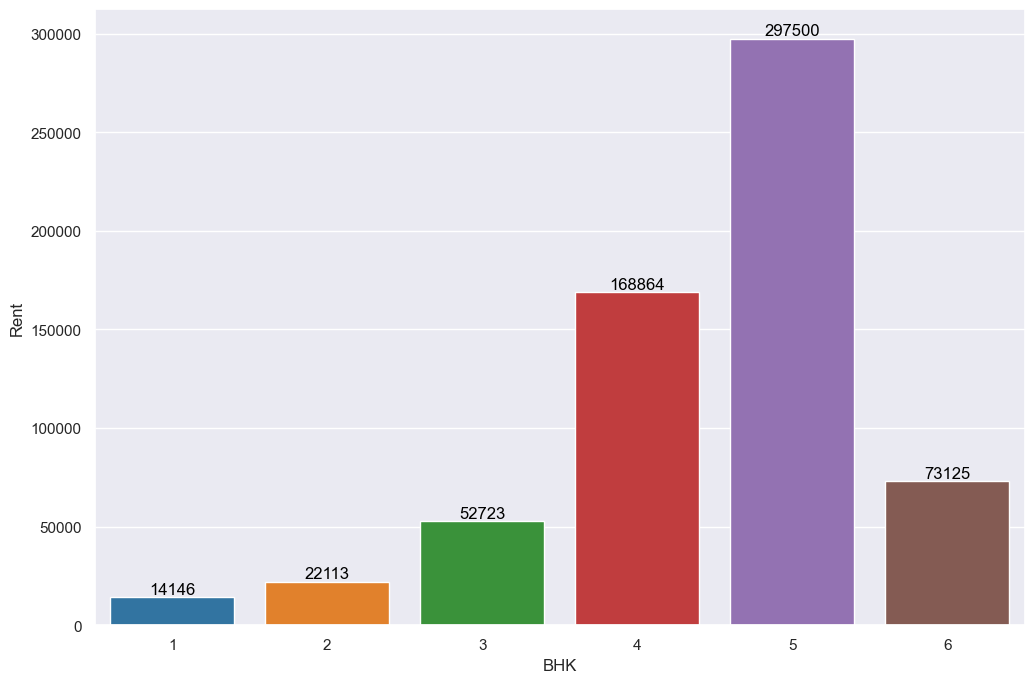

In [27]:
# Plotting Rent VS BHK
plt.figure(figsize=(12, 8))
ax = sb.barplot(x=data['BHK'], 
                y=data['Rent'], 
                palette='tab10',
                errorbar = None,
                hue = data['BHK'],
                legend = False)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

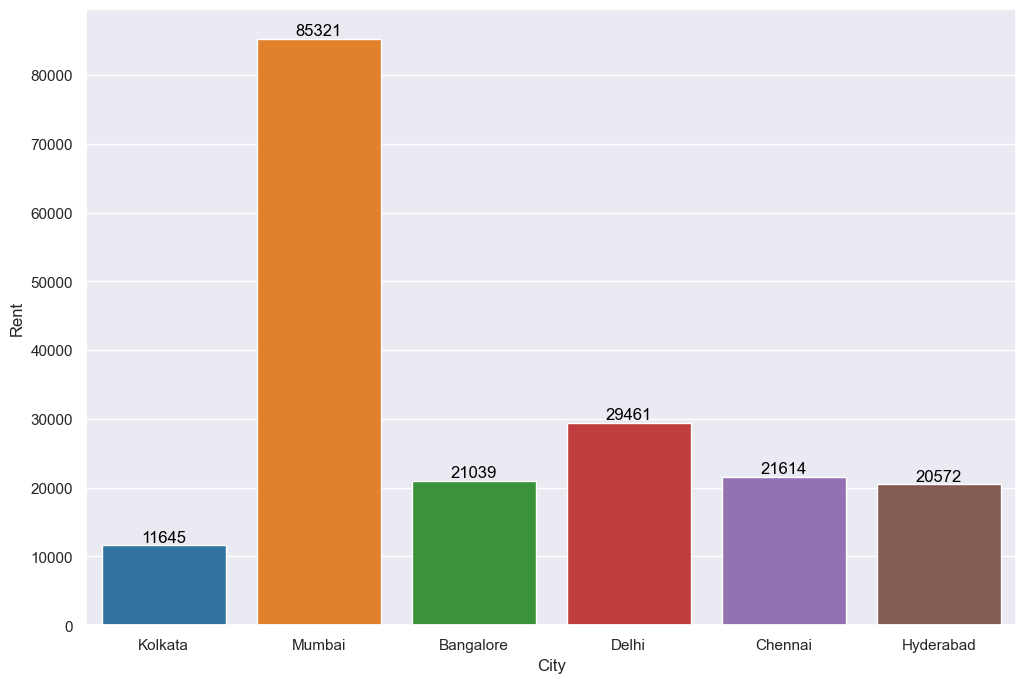

In [28]:
# Plotting Rent VS City
plt.figure(figsize=(12, 8))
ax = sb.barplot(x=data['City'], 
                 y=data['Rent'], 
                 palette='tab10',
                 errorbar = None,
                 hue = data['City'],
                 legend = False)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

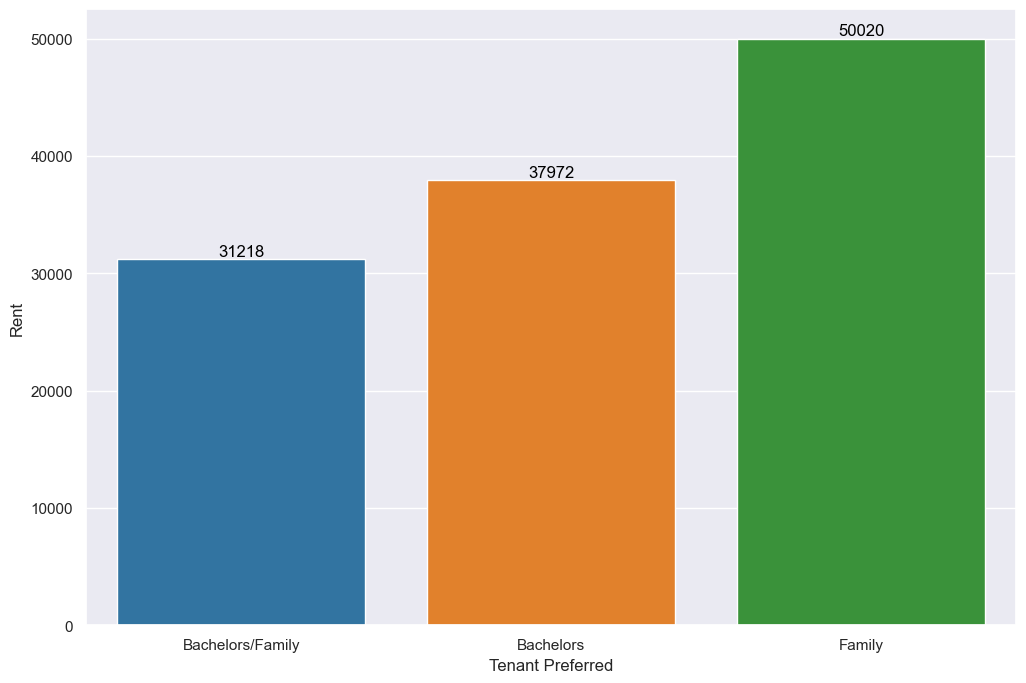

In [29]:
# Plotting Rent VS Furnishing Status
plt.figure(figsize=(12, 8))
ax = sb.barplot(x=data['Tenant Preferred'], 
                y=data['Rent'], 
                palette='tab10',
                errorbar = None,
                hue = data['Tenant Preferred'],
                legend = False)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

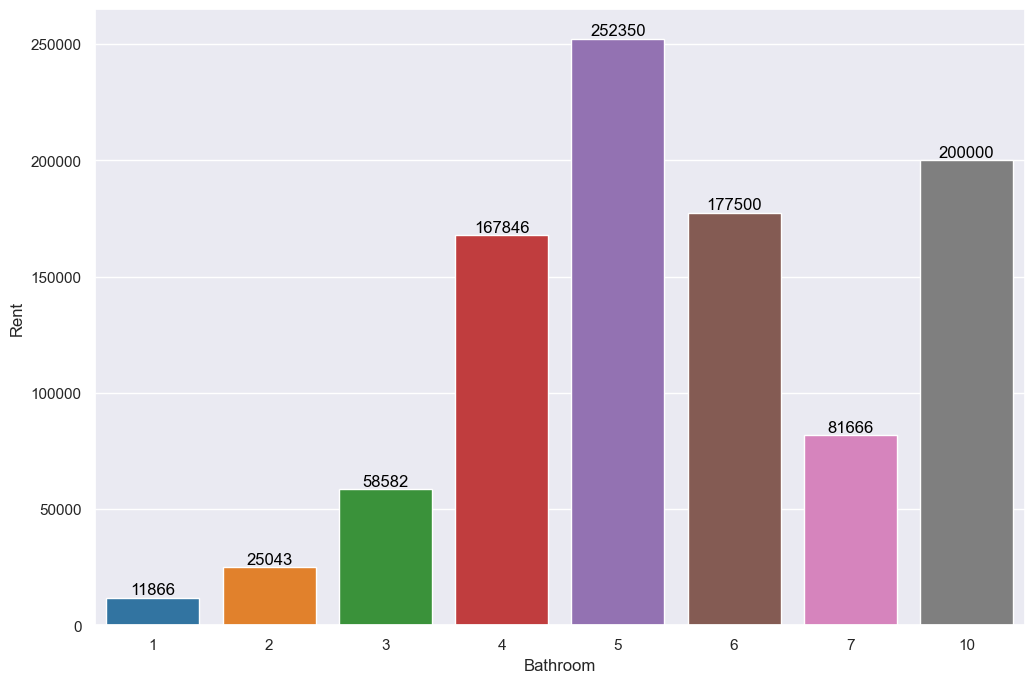

In [30]:
# Plotting Rent VS Furnishing Status
plt.figure(figsize=(12, 8))
ax = sb.barplot(x=data['Bathroom'], 
                y=data['Rent'], 
                palette='tab10',
                errorbar = None,
                hue = data['Bathroom'],
                legend = False)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

In [31]:
# Finding number of houses with 10 bathrooms
bath_10 = data[data['Bathroom'] == 10]
print("Number of Houses with 10 bathrooms:", len(bath_10))

Number of Houses with 10 bathrooms: 1


In [32]:
# convert catagorical to nurmeric values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Area Type'] = label_encoder.fit_transform(data['Area Type'])
data['Area Locality'] = label_encoder.fit_transform(data['Area Locality'])
data['City'] = label_encoder.fit_transform(data['City'])
data['Furnishing Status'] = label_encoder.fit_transform(data['Furnishing Status'])
data['Tenant Preferred'] = label_encoder.fit_transform(data['Tenant Preferred'])
data['Point of Contact'] = label_encoder.fit_transform(data['Point of Contact'])
if 'Posted On' in data.columns:
    data = data.drop(columns=['Posted On'])

In [33]:
# Dropping duplicate rows
print(data.duplicated().sum())
data = data.drop_duplicates()

8


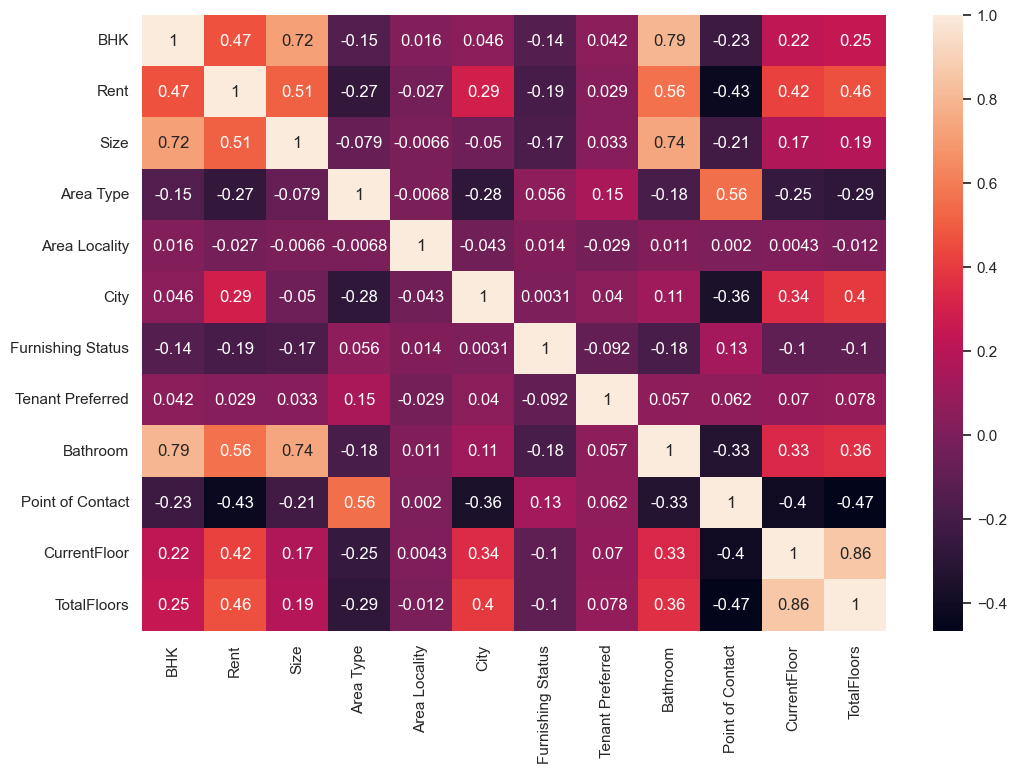

In [34]:
corr = data.corr(numeric_only = True)
plt.subplots(figsize=(12,8))
sb.heatmap(corr, vmax = 1, annot=True)
plt.show()

Part 3: Regression & Modeling

Part 3.1: Partitioning Data


In [36]:
# Separating data into independent and dependent variables
original_data = data
print(original_data.describe())
X = data.drop('Rent', axis = 1)
y = data['Rent']
# # # Using boxcox transformation to convert the data into a more normally distributed form
bc = boxcox(y)
y = bc[0]
lambda_ = bc[1]
# Splitting into train and test data set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

               BHK          Rent         Size    Area Type  Area Locality  \
count  4736.000000  4.736000e+03  4736.000000  4736.000000    4736.000000   
mean      2.083404  3.422418e+04   967.229941     1.515625    1090.952069   
std       0.831286  5.975023e+04   633.558961     0.500653     633.251202   
min       1.000000  1.200000e+03    10.000000     0.000000       0.000000   
25%       2.000000  1.000000e+04   550.000000     1.000000     550.750000   
50%       2.000000  1.600000e+04   850.000000     2.000000    1094.000000   
75%       3.000000  3.300000e+04  1200.000000     2.000000    1630.250000   
max       6.000000  1.200000e+06  8000.000000     2.000000    2234.000000   

              City  Furnishing Status  Tenant Preferred     Bathroom  \
count  4736.000000        4736.000000       4736.000000  4736.000000   
mean      2.455870           1.239443          0.925042     1.965372   
std       1.787365           0.684490          0.517975     0.883537   
min       0.000000

In [37]:
print(f'X_train size: {X_train.shape}')

X_train size: (3788, 11)


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
numeric_features = X.select_dtypes(include=['int64', 'int32','float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
# # 2. Define transformations for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handles missing values
    ('scaler', StandardScaler())                  # Standardizes numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handles missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encodes categorical features
])

# 3. Combine them using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 4. Create a full pipeline with a regression model at the end
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#5. Fit the model
model_pipeline.fit(X_train, Y_train)

# # 6. Predict on test set
y_pred = model_pipeline.predict(X_test)

Some machine learning algorithms are sensitive to magnitude in numerical variables, namely K-Nearest Neighbors, Support Vector, Ridge, and Lasso.

Therefore, the regressors should be standardized to minimize the downstream effect of magnitudes towards these algorithms.

In [40]:
# Fitting a linear regression model
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_hat = lr.predict(X_test)

# Retrieving the model intercepts, coefficients, and R-Squared Value
print("Linear Model Intercept:", lr.intercept_)
print("Linear Model Coefficients:", lr.coef_)

Linear Model Intercept: 2.8034679664712367
Linear Model Coefficients: [ 5.74518094e-03  5.88755350e-06 -2.24325141e-03  1.40589596e-07
  1.84466638e-03 -6.30965126e-03 -1.49043969e-04  8.25579774e-03
 -1.89066701e-02  9.91125324e-05  4.15875178e-04]


In [41]:
# Evaluation metrics
mae_lr = mean_absolute_error(Y_test, Y_hat)
mse_lr =  mean_squared_error(Y_test, Y_hat)
rmse_lr =  np.sqrt(mse_lr)

# Displaying the evaluation metrics
print("Mean Absolute Error:", mae_lr)
print("Mean Squared Error:", mse_lr)
print("Root Mean Squared Error:", rmse_lr)
print("\nR-Squared Value:", lr.score(X_test, Y_test))
print("R-Squared Adjusted Value:", 1 - ((1 - lr.score(X_test, Y_test)) * (len(Y_test)-1) / (len(Y_test)-X_test.shape[1]-1)))

Mean Absolute Error: 0.01319765817068017
Mean Squared Error: 0.0003036706661457162
Root Mean Squared Error: 0.017426148918958433

R-Squared Value: 0.6809103191935474
R-Squared Adjusted Value: 0.6771603336285144


The regressors in the model can explain about 67.71% of the variance in response.

Considering the error and the R-Squared values shown above, the linear regression model does not fit the data well.

#### Part 3.2.2: ANOVA Analysis

In [44]:
# Conducting ANOVA
def SSr(y, y_hat):
    total_SSr = 0
    y_mean = y.mean()
    for y_hat_ in y_hat:
        total_SSr += (y_hat_ - y_mean)**2
    return total_SSr

def SSe(y, y_hat):
    total_SSe = 0
    for y_, y_hat_ in zip(y, y_hat):
        total_SSe += (y_ - y_hat_)**2
    return total_SSe

# Conducting ANOVA Analysis on the entire dataset
sc_X = StandardScaler()
X_anova = sc_X.fit_transform(X)

# Fitting a new Linear Regression model
lr_anova = LinearRegression()
lr_anova.fit(X_anova, y)

LinearRegression()

In [45]:
# Calculating the predicted values and explained/unexplained variance
y_anova = lr_anova.predict(X_anova)
SSr_val = SSr(y, y_anova)
SSe_val = SSe(y, y_anova)

# Calculated SSr and SSe of the entire dataset
print("Explained Variance:", SSr_val)
print("Unexplained Variance:", SSe_val)

Explained Variance: 2.8394200671974468
Unexplained Variance: 1.3629465204871296


In [46]:
# Defining the number of regressors, coefficients, and samples
k = 20 # Number of Regressors, based on the length of the coefficients list
p = k + 1 # One greater than k since there is an intercept
n = len(y) # Number of data points
print("Number of regressors:", k)
print("Number of parameters:",p)
print("Number of samples:", n)

# Calculating Fo value
msr = SSr_val/k
mse = SSe_val/(n-p)
Fo = msr/mse
print("\nFo value:",Fo)

Number of regressors: 20
Number of parameters: 21
Number of samples: 4736

Fo value: 491.1368647117209


In [47]:
# Finding the f value
alpha = 0.05
f.ppf(q=1-alpha, dfn=k, dfd=(n-p))

1.5727552855289215

As seen from calculations above, the Fo value is greater than the value of F(0.05, k, n-p). Therefore, there is significant linear relationship between at least one of the regressors with the response variables.

#### 3.3.Machine Learning Modeling

In [50]:
X.describe() , y

(               BHK         Size    Area Type  Area Locality         City  \
 count  4736.000000  4736.000000  4736.000000    4736.000000  4736.000000   
 mean      2.083404   967.229941     1.515625    1090.952069     2.455870   
 std       0.831286   633.558961     0.500653     633.251202     1.787365   
 min       1.000000    10.000000     0.000000       0.000000     0.000000   
 25%       2.000000   550.000000     1.000000     550.750000     1.000000   
 50%       2.000000   850.000000     2.000000    1094.000000     2.000000   
 75%       3.000000  1200.000000     2.000000    1630.250000     4.000000   
 max       6.000000  8000.000000     2.000000    2234.000000     5.000000   
 
        Furnishing Status  Tenant Preferred     Bathroom  Point of Contact  \
 count        4736.000000       4736.000000  4736.000000       4736.000000   
 mean            1.239443          0.925042     1.965372          0.678843   
 std             0.684490          0.517975     0.883537          0.466

In [51]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Define models you want to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(random_state = 42),
    'Support Vector': SVR(),
    'CatBoost': CatBoostRegressor(verbose = 0, random_state = 42),
    'LightGBM': LGBMRegressor(verbose = 0, random_state = 42),
    'XGBoost' : XGBRegressor(random_state = 42),   
}

# Store results
results = {}
feature_importance = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, Y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(Y_test, y_pred)
    mse =  mean_squared_error(Y_test, y_pred)
    rmse =  np.sqrt(mse)
    r2 = pipeline.score(X_test, Y_test)
    r2_adj = 1 - ((1 - pipeline.score(X_test, Y_test)) * (len(Y_test)-1) / (len(Y_test)-X_test.shape[1]-1))
    results[name] = [mae, mse, rmse, r2, r2_adj]
    try:
        feature_importance[name] = model.feature_importances_

    except:
        pass
    print(name, "has been trained.")
    

Linear Regression has been trained.
Ridge Regression has been trained.
Lasso Regression has been trained.
Decision Tree has been trained.
Random Forest has been trained.
Gradient Boosting has been trained.
Support Vector has been trained.
CatBoost has been trained.
LightGBM has been trained.
XGBoost has been trained.


#### Part 3.3.2 Plotting the Evaluation Metrics

In [53]:

results_data = pd.DataFrame(results).T.rename(columns={0: 'MAE', 1: 'MSE', 2: 'RMSE', 3: 'R2', 4:'R2 Adjusted'})

print(results_data)

                        MAE       MSE      RMSE        R2  R2 Adjusted
Linear Regression  0.013198  0.000304  0.017426  0.680910     0.677160
Ridge Regression   0.013198  0.000304  0.017426  0.680903     0.677153
Lasso Regression   0.025007  0.000952  0.030858 -0.000582    -0.012341
Decision Tree      0.013629  0.000340  0.018443  0.642572     0.638372
Random Forest      0.010090  0.000183  0.013538  0.807423     0.805160
Gradient Boosting  0.010047  0.000182  0.013506  0.808315     0.806063
Support Vector     0.037044  0.002010  0.044835 -1.112256    -1.137079
CatBoost           0.009508  0.000165  0.012837  0.826835     0.824799
LightGBM           0.009695  0.000169  0.013019  0.821907     0.819815
XGBoost            0.010082  0.000187  0.013667  0.803719     0.801413


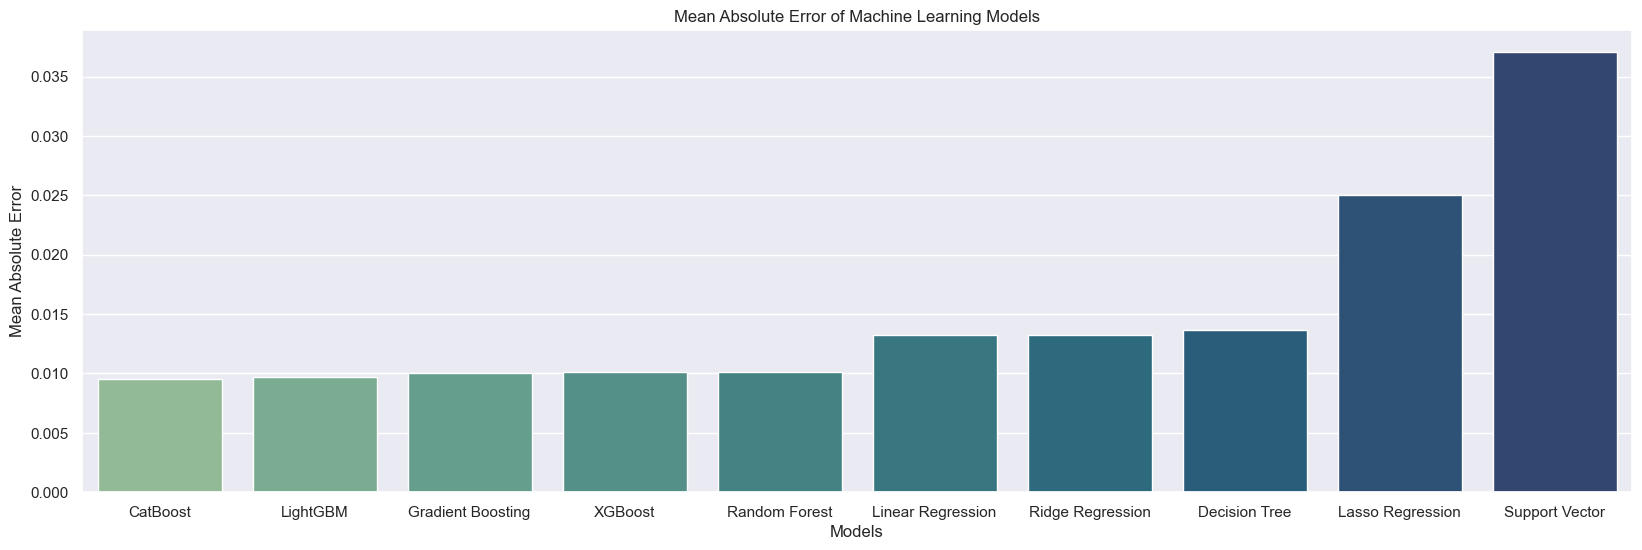

In [54]:
# Plotting Mean Absolute Error of each model
mae_ser = results_data['MAE'].sort_values()
plt.figure(figsize = (20, 6))
sb.barplot(x= mae_ser.index, y = mae_ser, palette = 'crest', hue = mae_ser.index, legend = False)
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error of Machine Learning Models');

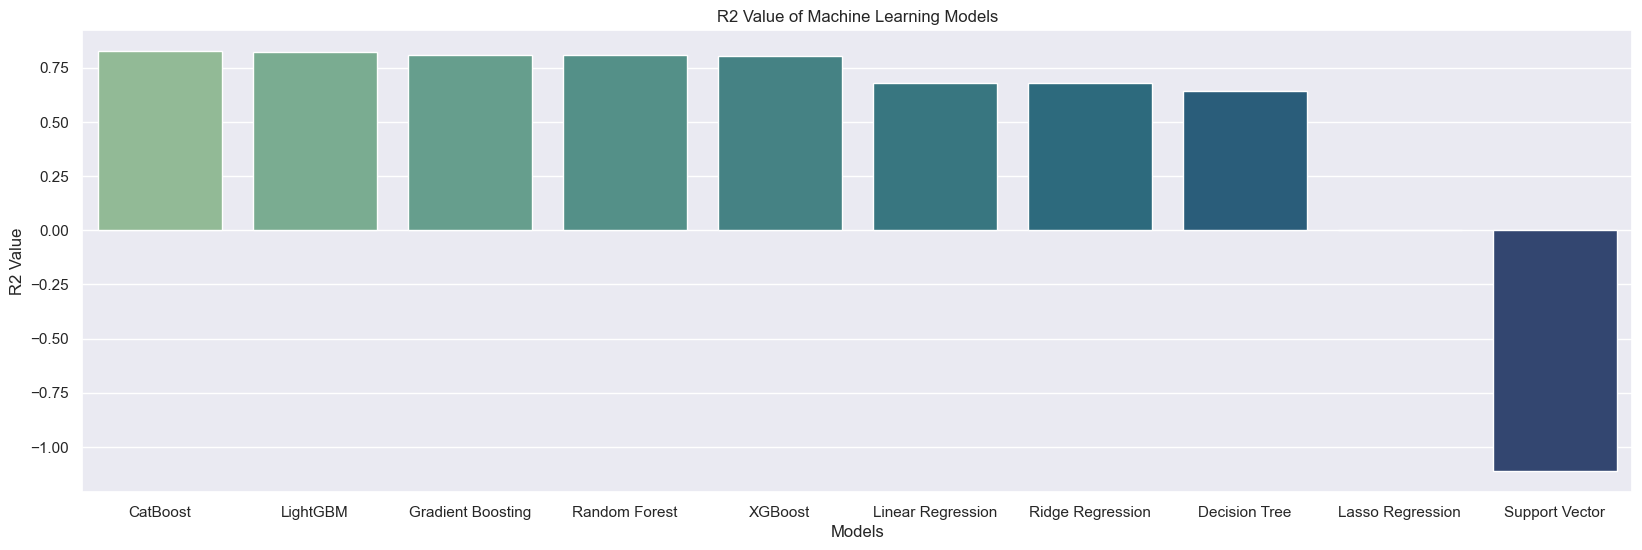

In [55]:
# Plotting R2 value of each model
r2_ser = results_data['R2'].sort_values(ascending = False)
plt.figure(figsize = (20, 6))
sb.barplot(x= r2_ser.index, y = r2_ser, palette = 'crest', hue = r2_ser.index, legend = False)
plt.xlabel('Models')
plt.ylabel('R2 Value')
plt.title('R2 Value of Machine Learning Models');

From the graphs above, CatBoost, LightGBM, Gradient Boosting, Random Forest, and XGBoost in order have the smallest MAE. On the other hand, CatBoost, Gradient Boosting, LightGBM, Random Forest, and XGBoost in order have the smallest MSE and RMSE and largest R2 values. These 5 algorithms will be used to determine the critical variables via feature importance.

#### Part 3.3.3 Feature Importance

In [58]:
# Getting feature names for plotting
feature_names = list(X.columns)
len(feature_names)

11

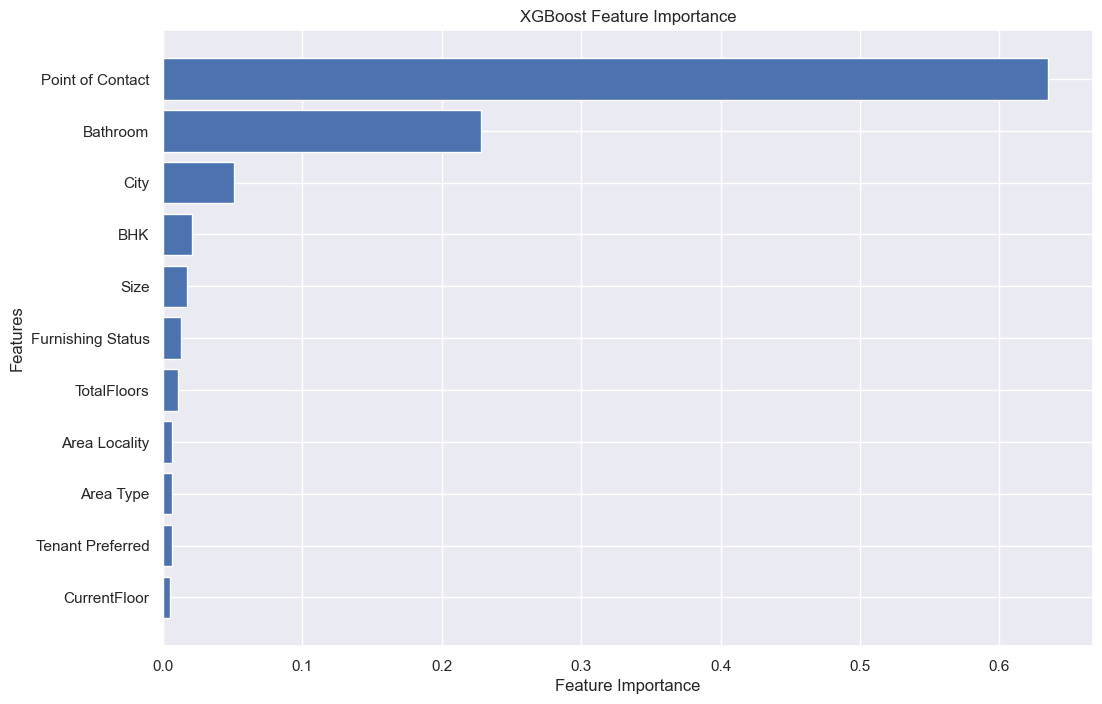

In [59]:
# Feature importance of the XGBoost model
xgb_feature_importance = feature_importance['XGBoost']
xgb_sorted_idx = np.argsort(xgb_feature_importance)
xgb_sorted_feature_importance = xgb_feature_importance[xgb_sorted_idx]
xgb_sorted_feature_names = [feature_names[i] for i in xgb_sorted_idx]

# Plotting it on a graph
plt.figure(figsize=(12, 8))
plt.barh(range(len(xgb_sorted_feature_importance)), xgb_sorted_feature_importance, align='center')
plt.yticks(range(len(xgb_sorted_feature_importance)), xgb_sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

In [60]:
import plotly.graph_objects as go

# important of each feature:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
fig = go.Figure(go.Bar(
            x=rf.feature_importances_,
            y=X_train.columns,
            orientation='h', marker_color='steelblue'))
fig.update_layout(template='plotly_dark', title='<b>Estimating feature importance with Forest model', title_x=0.5, 
                 xaxis_title="Feature importance", yaxis_title='Feature')
fig.show()

#### Part 4: Improvements
#### Part 4.1: Preparing the Dataset

In [176]:
# Initiate a new variable for the new dataset
data = data[['Rent', 'Bathroom','Size','City','Point of Contact','Area Type']]


In [178]:
# Defining the regressors and response
print(data)
X = data.drop('Rent', axis = 1)
y = data['Rent']
bc = boxcox(y)
y = bc[0]
lambda_ = bc[1]

# Splitting into train and test data set
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

       Rent  Bathroom  Size  City  Point of Contact  Area Type
0     10000         2  1100     4                 1          2
1     20000         1   800     4                 1          2
2     17000         1  1000     4                 1          2
3     10000         1   800     4                 1          2
4      7500         1   850     4                 1          1
...     ...       ...   ...   ...               ...        ...
4741  15000         2  1000     3                 1          1
4742  29000         3  2000     3                 1          2
4743  35000         3  1750     3                 0          1
4744  45000         2  1500     3                 0          1
4745  15000         2  1000     3                 1          1

[4736 rows x 6 columns]


In [180]:
# Standardizing the regressors
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

#### Part 4.2: Training the Machine Learning Models

In [183]:
# Defining the new models
new_models = {
    'Gradient Boosting': GradientBoostingRegressor(random_state = 42),
    'Random Forest' : RandomForestRegressor(random_state = 42),
    'CatBoost': CatBoostRegressor(verbose = 0, random_seed = 42),
    'XGBoost' : XGBRegressor(random_state = 42),    
}
results = {}

# Training all models and storing results in a dictionary
for name, model in new_models.items():
    model.fit(X_train1, y_train1)
    prediction = model.predict(X_test1)
    mae = mean_absolute_error(y_test1, prediction)
    mse =  mean_squared_error(y_test1, prediction)
    rmse =  np.sqrt(mse)
    r2 = model.score(X_test1, y_test1)
    r2_adj = 1 - ((1 - model.score(X_test1, y_test1)) * (len(y_test1)-1) / (len(y_test1)-X_test1.shape[1]-1))
    results[name] = [mae, mse, rmse, r2, r2_adj]
    print(name, "has been trained.")


Gradient Boosting has been trained.
Random Forest has been trained.
CatBoost has been trained.
XGBoost has been trained.


In [185]:
# Converting the "results" dictionary into a data frame and labeling the columns
new_results_data = pd.DataFrame(results).T.rename(columns={0: 'MAE', 1: 'MSE', 2: 'RMSE', 3: 'R2', 4:'R2 Adjusted'})
new_results_data

MAE       MSE      RMSE        R2  R2 Adjusted
Gradient Boosting  0.010874  0.000209  0.014444  0.780765     0.779602
Random Forest      0.011306  0.000228  0.015113  0.760002     0.758728
CatBoost           0.010842  0.000213  0.014608  0.775763     0.774573
XGBoost            0.011201  0.000245  0.015650  0.742653     0.741287

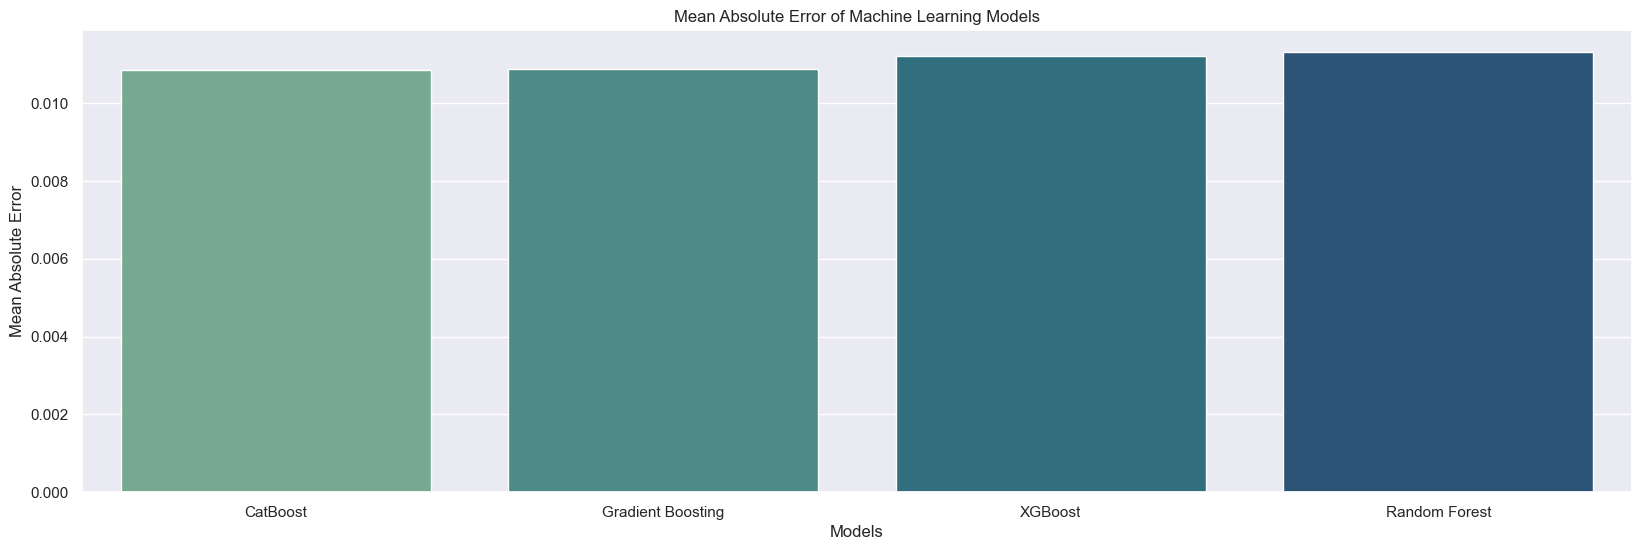

In [187]:
# Plotting Mean Absolute Error of each model
mae_ser = new_results_data['MAE'].sort_values()
plt.figure(figsize = (20, 6))
sb.barplot(x= mae_ser.index, y = mae_ser, palette = 'crest', hue = mae_ser.index, legend = False)
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error of Machine Learning Models');

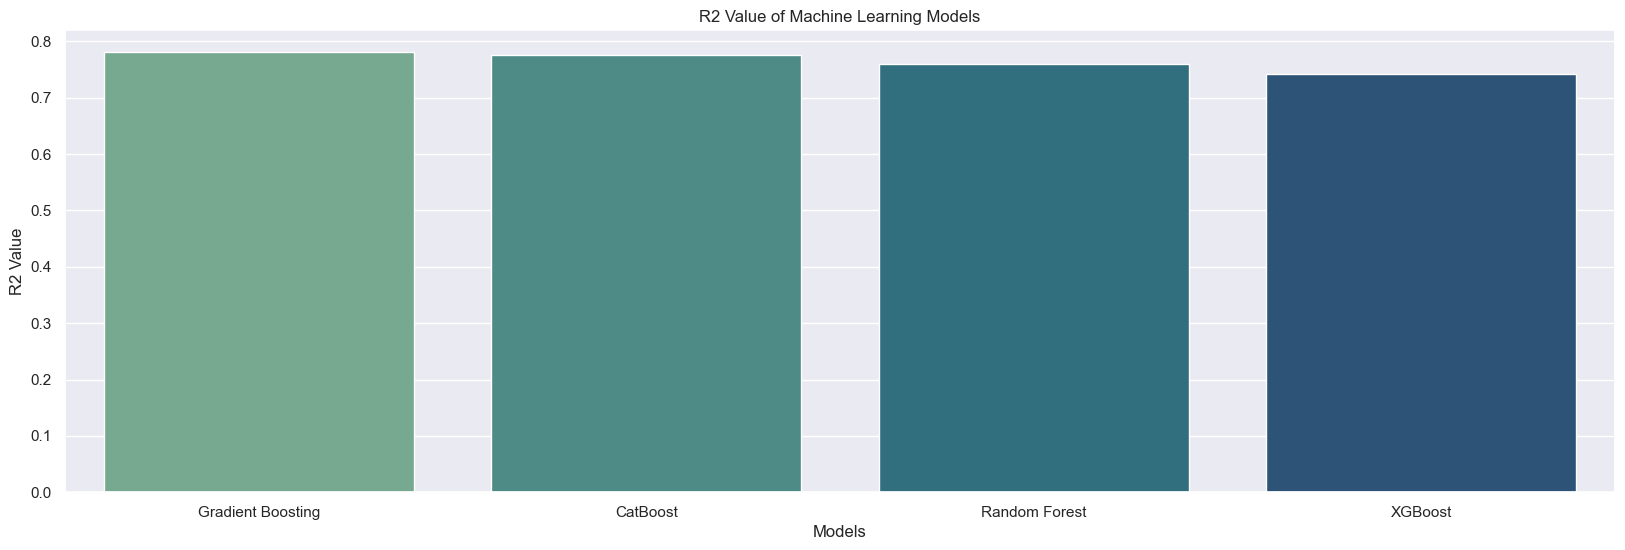

In [189]:
# Plotting R2 value of each model
r2_ser = new_results_data['R2'].sort_values(ascending = False)
plt.figure(figsize = (20, 6))
sb.barplot(x= r2_ser.index, y = r2_ser, palette = 'crest', hue = r2_ser.index, legend = False)
plt.xlabel('Models')
plt.ylabel('R2 Value')
plt.title('R2 Value of Machine Learning Models');

#### Part 4.3: Metrics Comparison

In [192]:
# Comparison of errors and R2 value
new_results_data = new_results_data.rename(columns = {"MAE": "Final MAE", "MSE": "Final MSE", "RMSE": "Final RMSE", "R2": "Final R2", "R2 Adjusted": "Final R2 Adjusted"})

# Combining the dataframe and rearranging the columns
comparison_data = pd.concat([results_data.loc[['Gradient Boosting', 'Random Forest', 'CatBoost', 'XGBoost']],new_results_data], axis = 1)
cols = comparison_data.columns.to_list()
cols = cols[0::5] + cols[1::5] + cols[2::5] + cols[3::5] + cols[4::5]
comparison_data = comparison_data[cols]
comparison_data

MAE  Final MAE       MSE  Final MSE      RMSE  \
Gradient Boosting  0.010047   0.010874  0.000182   0.000209  0.013506   
Random Forest      0.010090   0.011306  0.000183   0.000228  0.013538   
CatBoost           0.009508   0.010842  0.000165   0.000213  0.012837   
XGBoost            0.010082   0.011201  0.000187   0.000245  0.013667   

                   Final RMSE        R2  Final R2  R2 Adjusted  \
Gradient Boosting    0.014444  0.808315  0.780765     0.806063   
Random Forest        0.015113  0.807423  0.760002     0.805160   
CatBoost             0.014608  0.826835  0.775763     0.824799   
XGBoost              0.015650  0.803719  0.742653     0.801413   

                   Final R2 Adjusted  
Gradient Boosting           0.779602  
Random Forest               0.758728  
CatBoost                    0.774573  
XGBoost                     0.741287

Using the five features chosen, which are Bathroom, Size, City, Point of Contact, and Area Type, in contrast to all the features, yielded models with higher errors and a lower R2 value. Furthermore, the R2-adjusted value decreases when using feature importance. Therefore, from the decreasing R2-adjusted value, the models with all the features are better models than the ones using feature importance as more of the variation in the dependent variable is explained by the model.

In [213]:
 #Remaking the original data
data = original_data[['Rent', 'Bathroom','Size','City','Point of Contact','Area Type']]
X = data.drop('Rent', axis = 1)
y = data['Rent']
print(data)
# Using boxcox transformation to convert the data into a more normally distributed form
bc = boxcox(y)
y = bc[0]
lambda_ = bc[1]

# Splitting into train and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the regressors
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

       Rent  Bathroom  Size  City  Point of Contact  Area Type
0     10000         2  1100     4                 1          2
1     20000         1   800     4                 1          2
2     17000         1  1000     4                 1          2
3     10000         1   800     4                 1          2
4      7500         1   850     4                 1          1
...     ...       ...   ...   ...               ...        ...
4741  15000         2  1000     3                 1          1
4742  29000         3  2000     3                 1          2
4743  35000         3  1750     3                 0          1
4744  45000         2  1500     3                 0          1
4745  15000         2  1000     3                 1          1

[4736 rows x 6 columns]


In [215]:
# Combining the predictions of the models before feature importance
combined_predictions = (
    0.20 * inv_boxcox(new_models['CatBoost'].predict(X_test), lambda_) +
    0.20 * inv_boxcox(new_models['Gradient Boosting'].predict(X_test), lambda_) +
    0.20 * inv_boxcox(new_models['Random Forest'].predict(X_test), lambda_) + 
    0.20 * inv_boxcox(new_models['XGBoost'].predict(X_test), lambda_)
)

In [217]:
# Calculating the evaluation metrics
mae = mean_absolute_error(inv_boxcox(y_test, lambda_), combined_predictions)
mse = mean_squared_error(inv_boxcox(y_test, lambda_), combined_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(inv_boxcox(y_test, lambda_), combined_predictions)

# Displaying evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Squared Value:", r2)

Mean Absolute Error: 15207.684633802575
Mean Squared Error: 1989259131.6393692
Root Mean Squared Error: 44601.1113274027
R-Squared Value: 0.5964509745772566


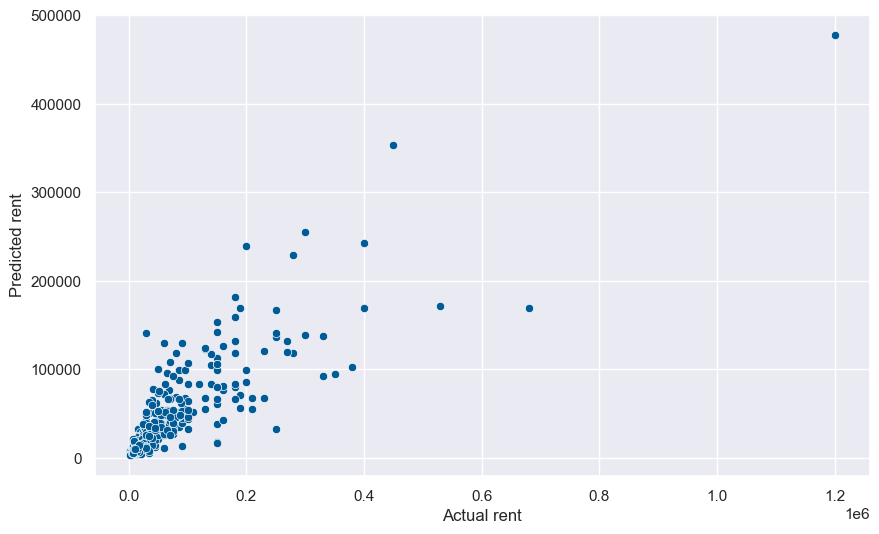

In [219]:
import seaborn as sns
sns.set()
plt.figure(figsize= (10, 6))
sns.scatterplot(x= inv_boxcox(y_test1, lambda_), y= combined_predictions, color= '#005b96')
plt.xlabel('Actual rent')
plt.ylabel('Predicted rent')
plt.show()

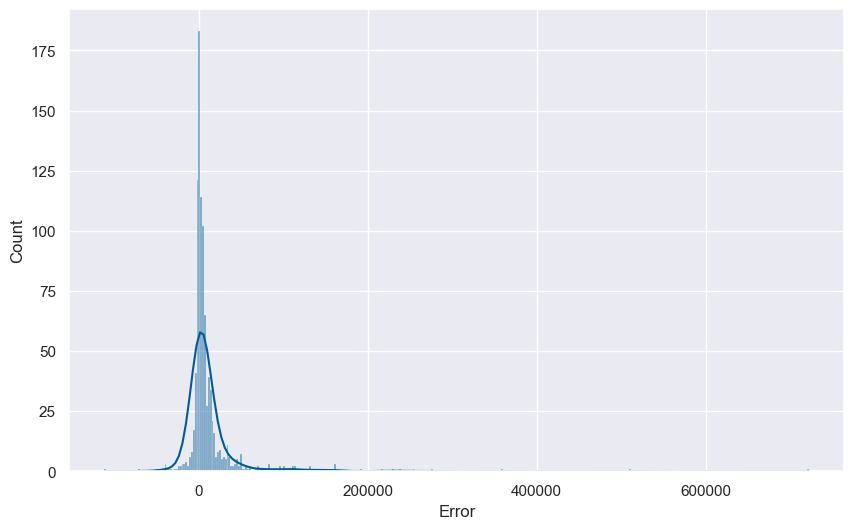

In [225]:
plt.figure(figsize = (10, 6))
sns.histplot(inv_boxcox(y_test, lambda_) - combined_predictions, color = '#005b96', kde= True)
plt.xlabel('Error');

In [ ]:
import joblib
data1=original_data
print(data1.describe())
data1 = data1.drop(columns= ['Area Type'])
X = data1.drop('Rent', axis = 1)

y = data1['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_train_scaled= pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_train = X_train.drop(columns= ['Area Type'])
# X_train_scaled = X_train_scaled.drop(columns= ['Area Type'])
joblib.dump(scaler, 'scaler.pkl')
columns = X_train.columns
print(columns)
print(X_train_scaled)
joblib.dump(columns, 'columns.pkl')

### select best model based on evaluation

In [ ]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train_scaled, y_train)  # Fit the model with training data

new_data = np.array([[0.056772, -0.560958,  0.470287, 1.023278, 1.096230, 0.151256, -1.147986, 0.571755, -0.434325, -0.551151]])
new_prediction = xgboost_model.predict(new_data)

print("Prediction for new data:", new_prediction)

In [ ]:
#grid Search
from sklearn.model_selection import GridSearchCV
# Define the parameters
param_grid = {
     "n_estimators": [10, 100, 200],
        "learning_rate": [0.1, 0.5],
        "max_depth": [2, 20],
        "reg_alpha": [0, 1],            # L1 regularization to reduce overfitting
        "reg_lambda": [1, 10],           # L2 regularization to reduce overfitting
        "subsample": [0.8, 1.0],            # Row sampling to improve generalization
        "colsample_bytree": [0.8, 1.0]
}


xgboost_model = XGBRegressor()


grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, 
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best R2 score: ", grid_search.best_score_)


best_xgboost_gridsearch = grid_search.best_estimator_

#predict data after grid search tunning 

new_data = np.array([[0.056772, -0.560958,  0.470287, 1.023278, 1.096230, 0.151256, -1.147986, 0.571755, -0.434325, -0.551151]])
new_prediction_grid_search = best_xgboost_gridsearch.predict(new_data)

print("Prediction for new data using Grid Search tuned model:", new_prediction_grid_search)



<h2 style="color: blue; text-align: left;">Hyperparameter Tuning</h2>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy

# Define the parameters
param_dist = {
   'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


xgboost_model = XGBRegressor()

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_dist, 
                                    n_iter=10, scoring='r2', cv=5, n_jobs=-1, 
                                    verbose=1, random_state=42)


random_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best R2 score: ", random_search.best_score_)


best_xgboost_random = random_search.best_estimator_

#predict data after grid search tunning 

new_data = np.array([[0.056772, -0.560958,  0.470287, 1.023278, 1.096230, 0.151256, -1.147986, 0.571755, -0.434325, -0.551151]])
new_prediction_random_search = best_xgboost_gridsearch.predict(new_data)

print("Prediction for new data using Random Search tuned model:", new_prediction_random_search)

<h3 style="color: black; text-align: left;">save final enchaced model for use in deployed system later</h3>

In [ ]:
# finaly dump models for use later in deployed system 

import joblib

# Save the RandomizedSearchCV model
joblib.dump(best_xgboost_random, 'best_xgboost_random.joblib')

# Save the GridSearchCV model
joblib.dump(best_xgboost_gridsearch, 'best_xgboost_gridsearch.joblib')


In [ ]:
# use imported dump for predict 
import joblib

# Load the RandomizedSearchCV model
loaded_best_xgboost_random = joblib.load('best_xgboost_random.joblib')

# Load the GridSearchCV model
loaded_best_xgboost_gridsearch = joblib.load('best_xgboost_gridsearch.joblib')

# Predict using the loaded RandomizedSearchCV model
new_data = np.array([[0.056772, -0.560958, 0.470287, 1.023278, 1.096230, 0.151256, -1.147986, 0.571755, -0.434325, -0.551151]])
new_prediction_random_search = loaded_best_xgboost_random.predict(new_data)

print("Prediction for new data using loaded Random Search tuned model:", new_prediction_random_search)

# Predict using the loaded GridSearchCV model
new_prediction_grid_search = loaded_best_xgboost_gridsearch.predict(new_data)

print("Prediction for new data using loaded Grid Search tuned model:", new_prediction_grid_search)
